Loading images...
Loaded 8 plant images from 'plants' folder (scaled to 50%)
Grass: (256, 256) (RGBA)
Panda: (256, 224) (RGBA)
Plant images: 8

Slicing images into tiles...
Grass tiles: 256
Panda sprites: 56

Generating composite images...
  Could not place plant without overlapping, skipping...
  Could not place plant without overlapping, skipping...


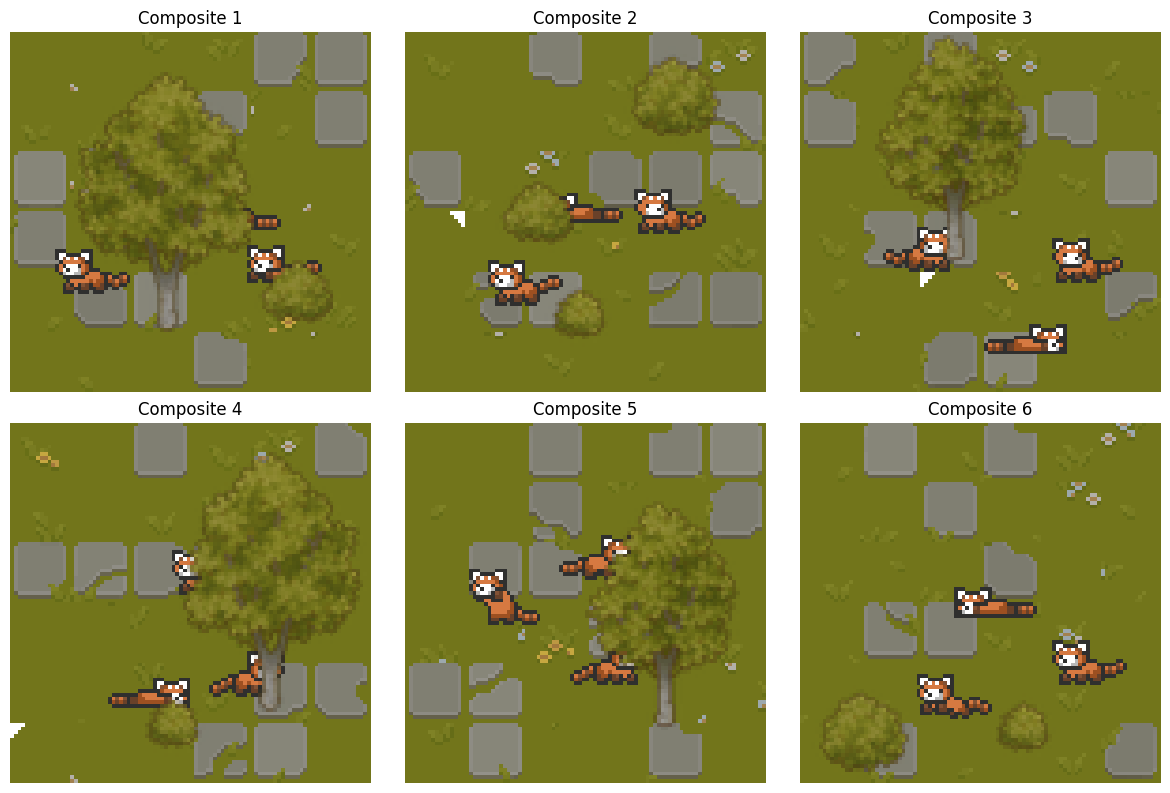

Done! Images saved.


In [1]:
# Complete Image Slicing and Layering Pipeline
# ================================================

from PIL import Image, ImageOps
import numpy as np
import random
import matplotlib.pyplot as plt
import json
import os
import glob

print("Loading images...")
grass_img = Image.open('Grass.png')
panda_img = Image.open('Panda.png').convert('RGBA')

# Load all plant images from the plants folder and scale them down to 50%
plant_files = glob.glob('plants/*.png')
plant_images = []
for plant_file in plant_files:
    plant_img = Image.open(plant_file).convert('RGBA')
    # Scale down to 50%
    new_width = plant_img.width // 2
    new_height = plant_img.height // 2
    plant_img = plant_img.resize((new_width, new_height), Image.LANCZOS)
    plant_images.append(plant_img)

print(f"Loaded {len(plant_images)} plant images from 'plants' folder (scaled to 50%)")

# Load the JSON file for panda sprite coordinates
with open('Panda.json', 'r') as f:
    panda_json = json.load(f)

print(f"Grass: {grass_img.size} ({grass_img.mode})")
print(f"Panda: {panda_img.size} ({panda_img.mode})")
print(f"Plant images: {len(plant_images)}")

def slice_tileset(image, tile_width, tile_height):
    """Slice an image into individual tiles"""
    tiles = []
    img_width, img_height = image.size
    rows = img_height // tile_height
    cols = img_width // tile_width
    
    for row in range(rows):
        for col in range(cols):
            left = col * tile_width
            upper = row * tile_height
            right = left + tile_width
            lower = upper + tile_height
            tile = image.crop((left, upper, right, lower))
            tiles.append(tile)
    
    return tiles

# Slice all images
print("\nSlicing images into tiles...")
grass_tiles = slice_tileset(grass_img, 16, 16)  # 16x16 grass tiles

# Slice panda sprites using JSON coordinates
panda_tiles = []
for frame_name, frame_data in panda_json['frames'].items():
    frame_info = frame_data['frame']
    x, y, w, h = frame_info['x'], frame_info['y'], frame_info['w'], frame_info['h']
    panda_sprite = panda_img.crop((x, y, x + w, y + h))
    panda_tiles.append(panda_sprite)

print(f"Grass tiles: {len(grass_tiles)}")
print(f"Panda sprites: {len(panda_tiles)}")

def check_overlap(new_pos, existing_positions, min_distance=20):
    """Check if a new position overlaps too much with existing positions"""
    new_x, new_y = new_pos
    for ex_x, ex_y in existing_positions:
        distance = ((new_x - ex_x)**2 + (new_y - ex_y)**2)**0.5
        if distance < min_distance:
            return True
    return False

def check_plant_overlap(plant_pos, plant_size, panda_positions, panda_size=32, min_distance=15):
    """Check if a plant overlaps with any pandas"""
    plant_x, plant_y = plant_pos
    plant_w, plant_h = plant_size
    plant_center_x = plant_x + plant_w // 2
    plant_center_y = plant_y + plant_h // 2
    
    for panda_x, panda_y in panda_positions:
        panda_center_x = panda_x + panda_size // 2
        panda_center_y = panda_y + panda_size // 2
        
        distance = ((plant_center_x - panda_center_x)**2 + (plant_center_y - panda_center_y)**2)**0.5
        if distance < (panda_size // 2 + min_distance):
            return True
    return False

def check_plant_plant_overlap(plant_pos, plant_size, existing_plant_positions, min_distance=10):
    """Check if a plant overlaps with other existing plants"""
    plant_x, plant_y = plant_pos
    plant_w, plant_h = plant_size
    plant_center_x = plant_x + plant_w // 2
    plant_center_y = plant_y + plant_h // 2
    
    for existing_plant in existing_plant_positions:
        ex_x, ex_y, ex_w, ex_h = existing_plant
        ex_center_x = ex_x + ex_w // 2
        ex_center_y = ex_y + ex_h // 2
        
        distance = ((plant_center_x - ex_center_x)**2 + (plant_center_y - ex_center_y)**2)**0.5
        # Use average of both plant sizes for distance calculation
        avg_size = (max(plant_w, plant_h) + max(ex_w, ex_h)) / 4
        if distance < (avg_size + min_distance):
            return True
    return False

def create_layered_image(grass_tiles, panda_tiles, plant_images, output_size=(128, 128)):
    """Create composite image with random tiles layered"""
    GRASS_SIZE = 16
    PANDA_SIZE = 32  # Updated from 48 to 32 based on JSON
    
    # Create RGB composite (no alpha in final output)
    composite = Image.new('RGB', output_size, (255, 255, 255))
    
    # Layer 1: Grass background - with random flipping
    tiles_wide = output_size[0] // GRASS_SIZE
    tiles_high = output_size[1] // GRASS_SIZE
    
    for row in range(tiles_high):
        for col in range(tiles_wide):
            grass_tile = random.choice(grass_tiles)
            
            # Randomly flip horizontally (50% chance)
            if random.random() < 0.5:
                grass_tile = ImageOps.mirror(grass_tile)
            
            x = col * GRASS_SIZE
            y = row * GRASS_SIZE
            composite.paste(grass_tile, (x, y))
    
    # Layer 2: Multiple Pandas (3-4) - with random flipping
    num_pandas = random.randint(3, 4)
    center_x = output_size[0] // 2
    center_y = output_size[1] // 2
    radius = min(output_size[0], output_size[1]) // 3  # Circle radius
    
    panda_positions = []
    max_attempts = 50
    
    for i in range(num_pandas):
        placed = False
        for attempt in range(max_attempts):
            # Random angle for circular arrangement
            angle = random.uniform(0, 2 * 3.14159)
            # Random distance from center (within radius)
            distance = random.uniform(radius * 0.3, radius)
            
            # Calculate position
            panda_x = int(center_x + distance * np.cos(angle) - PANDA_SIZE // 2)
            panda_y = int(center_y + distance * np.sin(angle) - PANDA_SIZE // 2)
            
            # Make sure it's within bounds
            panda_x = max(0, min(panda_x, output_size[0] - PANDA_SIZE))
            panda_y = max(0, min(panda_y, output_size[1] - PANDA_SIZE))
            
            # Check if it overlaps too much with existing pandas
            if not check_overlap((panda_x, panda_y), panda_positions, min_distance=20):
                # Place the panda
                panda_sprite = random.choice(panda_tiles)
                
                # Randomly flip horizontally (50% chance)
                if random.random() < 0.5:
                    panda_sprite = ImageOps.mirror(panda_sprite)
                
                if panda_sprite.mode == 'RGBA':
                    composite.paste(panda_sprite, (panda_x, panda_y), panda_sprite)
                else:
                    composite.paste(panda_sprite, (panda_x, panda_y))
                
                panda_positions.append((panda_x, panda_y))
                placed = True
                break
        
        if not placed:
            # If couldn't place after max attempts, just place randomly
            panda_x = random.randint(0, output_size[0] - PANDA_SIZE)
            panda_y = random.randint(0, output_size[1] - PANDA_SIZE)
            panda_sprite = random.choice(panda_tiles)
            
            # Randomly flip horizontally (50% chance)
            if random.random() < 0.5:
                panda_sprite = ImageOps.mirror(panda_sprite)
            
            if panda_sprite.mode == 'RGBA':
                composite.paste(panda_sprite, (panda_x, panda_y), panda_sprite)
            else:
                composite.paste(panda_sprite, (panda_x, panda_y))
            panda_positions.append((panda_x, panda_y))
    
    # Layer 3: Plants (1-3 random plants from folder)
    if plant_images:
        num_plants = random.randint(1, 3)
        selected_plants = random.sample(plant_images, min(num_plants, len(plant_images)))
        
        plant_positions = []  # Track placed plants: (x, y, w, h)
        
        for plant_img in selected_plants:
            # Randomly flip horizontally (50% chance)
            if random.random() < 0.5:
                plant_img = ImageOps.mirror(plant_img)
            
            plant_w, plant_h = plant_img.size
            placed = False
            max_plant_attempts = 30
            
            for attempt in range(max_plant_attempts):
                # Random position for each plant
                plant_x = random.randint(0, max(0, output_size[0] - plant_w))
                plant_y = random.randint(0, max(0, output_size[1] - plant_h))
                
                # Check if plant overlaps with any pandas
                if check_plant_overlap((plant_x, plant_y), (plant_w, plant_h), panda_positions, PANDA_SIZE/5):
                    continue
                
                # Check if plant overlaps with other plants
                if check_plant_plant_overlap((plant_x, plant_y), (plant_w, plant_h), plant_positions):
                    continue
                
                # If no overlaps, place the plant
                if plant_img.mode == 'RGBA':
                    composite.paste(plant_img, (plant_x, plant_y), plant_img)
                else:
                    composite.paste(plant_img, (plant_x, plant_y))
                plant_positions.append((plant_x, plant_y, plant_w, plant_h))
                placed = True
                break
            
            # If couldn't place without overlap, skip this plant
            if not placed:
                print(f"  Could not place plant without overlapping, skipping...")
    
    return composite

print("\nGenerating composite images...")

# Single image
sample = create_layered_image(grass_tiles, panda_tiles, plant_images, output_size=(128, 128))
sample.save('composite_sample.png')

# Multiple images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    img = create_layered_image(grass_tiles, panda_tiles, plant_images, output_size=(96, 96))
    axes[i].imshow(img)
    axes[i].set_title(f'Composite {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('composites_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print("Done! Images saved.")